In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from xgboost import XGBRegressor
import scipy
import calendar
import optuna
import os

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer

# metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from statsmodels.tsa.deterministic import DeterministicProcess

/home/raziel/Documents/Kiosko/Challenge-Data-Scientist/env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from utils.reg_helper_functions import *
from utils.reg_helper_functions import regression_metrics_df, calculate_cv_metrics_regression, combine_and_format_metrics
from utils.reg_helper_functions import plot_regression_models_metrics, plot_residuals, plot_residuals_sns
from utils.reg_helper_functions import plot_learning_curves_reg, plot_regression_metrics

from utils.helper_functions import *
from utils.helper_functions import plot_numerical_feature_comparison, plot_feature_distributions
from utils.helper_functions import plot_category_distribution, plot_category_distribution_by_group

In [3]:
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)

%config InlineBackend.figure_format = 'retina'

In [4]:
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax


def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("365D") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

In [5]:
# Archivo raíz
data_folder = 'data/'

train_data_encoded = pd.read_csv(data_folder+'train_data_encoded.csv')

In [6]:
train_data_encoded = train_data_encoded.astype({
    'store_nbr': 'int64',
    'onpromotion': 'int64',
    'family': 'int64',
    'perishable': 'int64',
    'weekday': 'int64',
    'year': 'int64',
    'day': 'int64',
    'is_weekend': 'int64',
    'sales_lag_7': 'float64',
    'sales_lag_30': 'float64',
    'sales_roll_mean_7': 'float64',
    'sales_roll_mean_30': 'float64',
    'sales_ewm_alpha_095_lag_7': 'float64',
    'sales_ewm_alpha_095_lag_30': 'float64',
    'sales_ewm_alpha_09_lag_7': 'float64',
    'sales_ewm_alpha_09_lag_30': 'float64',
    'sales_ewm_alpha_08_lag_7': 'float64',
    'sales_ewm_alpha_08_lag_30': 'float64'
})

In [7]:
# Split back into train and test data
test_data_encoded = train_data_encoded[train_data_encoded['date']
                                       > '2017-05-00'].copy()
train_data_encoded = train_data_encoded[train_data_encoded['date']
                                        <= '2017-05-00'].copy()

In [8]:
train_data_encoded.head()

,date,store_nbr,unit_sales,onpromotion,family,perishable,cluster,type_holiday,weekday,year,...,sales_lag_7,sales_lag_30,sales_roll_mean_7,sales_roll_mean_30,sales_ewm_alpha_095_lag_7,sales_ewm_alpha_095_lag_30,sales_ewm_alpha_09_lag_7,sales_ewm_alpha_09_lag_30,sales_ewm_alpha_08_lag_7,sales_ewm_alpha_08_lag_30
0,2014-04-01,0,1.0,0,9,0,4,4,1,2014,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,2014-04-01,0,3.0,0,3,1,4,4,1,2014,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,2014-04-01,0,1.0,0,9,0,4,4,1,2014,...,0.0,0.0,1.172208,-0.612083,0.0,0.0,0.0,0.0,0.0,0.0
3,2014-04-01,0,11.0,0,9,0,4,4,1,2014,...,0.0,0.0,2.312253,3.649751,0.0,0.0,0.0,0.0,0.0,0.0
4,2014-04-01,0,4.0,0,9,0,4,4,1,2014,...,0.0,0.0,3.399322,5.535918,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
test_data_encoded.head()

,date,store_nbr,unit_sales,onpromotion,family,perishable,cluster,type_holiday,weekday,year,...,sales_lag_7,sales_lag_30,sales_roll_mean_7,sales_roll_mean_30,sales_ewm_alpha_095_lag_7,sales_ewm_alpha_095_lag_30,sales_ewm_alpha_09_lag_7,sales_ewm_alpha_09_lag_30,sales_ewm_alpha_08_lag_7,sales_ewm_alpha_08_lag_30
62242899,2017-05-01,0,1.0,0,9,0,4,4,0,2017,...,1.0,1.0,1.466336,1.926384,1.047619,1.002500,1.090900,1.01000,1.166400,1.040000
62242900,2017-05-01,0,4.0,0,9,0,4,4,0,2017,...,2.0,1.0,0.538678,5.496483,1.952381,1.000125,1.909090,1.00100,1.833280,1.008000
62242901,2017-05-01,0,4.0,0,9,0,4,4,0,2017,...,6.0,1.0,0.905561,1.214370,5.797619,1.000006,5.590909,1.00010,5.166656,1.001600
62242902,2017-05-01,0,1.0,0,9,0,4,4,0,2017,...,1.0,6.0,0.631371,1.409947,1.239881,5.750000,1.459091,5.50001,1.833331,5.000320
62242903,2017-05-01,0,4.0,0,6,1,4,4,0,2017,...,3.0,3.0,2.682214,1.295288,2.946485,2.972817,2.886147,2.94247,2.746785,2.869251


In [12]:
# Define the target and features
X = train_data_encoded.drop(columns=['unit_sales'])
y = train_data_encoded['unit_sales']

In [13]:
# Assuming train_data_encoded is your preprocessed DataFrame sorted by time
subset_frac = 0.20
subset_size = int(len(train_data_encoded) * subset_frac)
subsample_train_data = train_data_encoded.iloc[-subset_size:]

In [14]:
# Split features and target
X_subsample = subsample_train_data.drop(columns=["unit_sales"])
y_subsample = subsample_train_data["unit_sales"]

In [15]:
# Time-based train-validation split within the subset
split_index = int(0.8 * len(X_subsample))
X_sub_train, X_sub_val = X_subsample.iloc[:
                                          split_index], X_subsample.iloc[split_index:]
y_sub_train, y_sub_val = y_subsample.iloc[:
                                          split_index], y_subsample.iloc[split_index:]

In [12]:
# Define the Optuna objective function
def objective(trial):
    params = {
        # 'tree_method': 'gpu_hist',
        'tree_method': 'hist',
        'n_jobs': -1,
        'objective': 'reg:squarederror',
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),
        'verbosity': 2,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'max_depth': trial.suggest_int('max_depth', 6, 14),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 10, 24),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.001, 1, log=True),
        'colsample_bynode': trial.suggest_float('colsample_bynode', 0.3, 0.9)
    }

    model = XGBRegressor(**params)

    model.fit(X_sub_train, y_sub_train, eval_set=[
              (X_sub_val, y_sub_val)],verbose=False)
    y_pred = model.predict(X_sub_val)
    rmse = mean_squared_error(y_sub_val, y_pred, squared=False)
    return rmse

In [18]:
# Create and optimize the study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

[I 2024-09-06 16:02:52,684] A new study created in memory with name: no-name-474e1620-a5bc-4b28-9fb6-6bf8b86628a7
/home/raziel/Documents/Kiosko/Challenge-Data-Scientist/env/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-09-06 16:06:02,983] Trial 0 finished with value: 18.82571191841221 and parameters: {'n_estimators': 155, 'learning_rate': 0.015567400531067269, 'max_depth': 12, 'subsample': 0.9198616918855032, 'colsample_bytree': 0.5671539025090804, 'min_child_weight': 12, 'reg_lambda': 0.00950629298051212, 'colsample_bynode': 0.8120773322460428}. Best is trial 0 with value: 18.82571191841221.
/home/raziel/Documents/Kiosko/Challenge-Data-Scientist/env/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be

In [19]:
# Print the best parameters
best_params_optuna = study.best_params
print(f"Best parameters found with Optuna: {best_params_optuna}")

Best parameters found with Optuna: {'n_estimators': 299, 'learning_rate': 0.010196240577626036, 'max_depth': 14, 'subsample': 0.6264220866247561, 'colsample_bytree': 0.8084523598374298, 'min_child_weight': 23, 'reg_lambda': 0.030801527526937537, 'colsample_bynode': 0.5649473449255678}


In [16]:

params = {
    # 'tree_method': 'gpu_hist',
    'tree_method': 'hist',
    'n_jobs': -1,
    'objective': 'reg:squarederror',
    'n_estimators': 299,
    'verbosity': 2,
    'learning_rate': 0.010196240577626036,
    'max_depth': 14,
    'subsample': 0.6264220866247561,
    'colsample_bytree': 0.8084523598374298,
    'min_child_weight': 23,
    'reg_lambda': 0.030801527526937537,
    'colsample_bynode': 0.5649473449255678
}

model = XGBRegressor(**params)

In [17]:
# Assuming train_data_encoded is your preprocessed DataFrame sorted by time
subset_frac = 0.20
subset_size = int(len(train_data_encoded) * subset_frac)
subsample_train_data = train_data_encoded.iloc[-subset_size:]

In [18]:
# Split features and target
X_subsample = subsample_train_data.drop(columns=["unit_sales"])
y_subsample = subsample_train_data["unit_sales"]

In [19]:
# Time-based train-validation split within the subset
split_index = int(0.8 * len(X_subsample))
X_sub_train, X_sub_val = X_subsample.iloc[:
                                          split_index], X_subsample.iloc[split_index:]
y_sub_train, y_sub_val = y_subsample.iloc[:
                                          split_index], y_subsample.iloc[split_index:]

In [20]:
model.fit(X_subsample, y_subsample, verbose=True)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=0.5649473449255678,
             colsample_bytree=0.8084523598374298, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.010196240577626036, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=14, max_leaves=None,
             min_child_weight=23, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=299, n_jobs=-1,
             num_parallel_tree=None, random_state=None, ...)

In [23]:
test_data_encoded_X = test_data_encoded[X.columns]
test_data_encoded_y = test_data_encoded['unit_sales']

In [25]:
# Predict on the test data
y_pred = pd.Series(model.predict(X), index=train_data_encoded.index)

In [26]:
y_fore = pd.Series(model.predict(test_data_encoded_X),
                   index=test_data_encoded_X.index)

/home/raziel/Documents/Kiosko/Challenge-Data-Scientist/env/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/raziel/Documents/Kiosko/Challenge-Data-Scientist/env/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


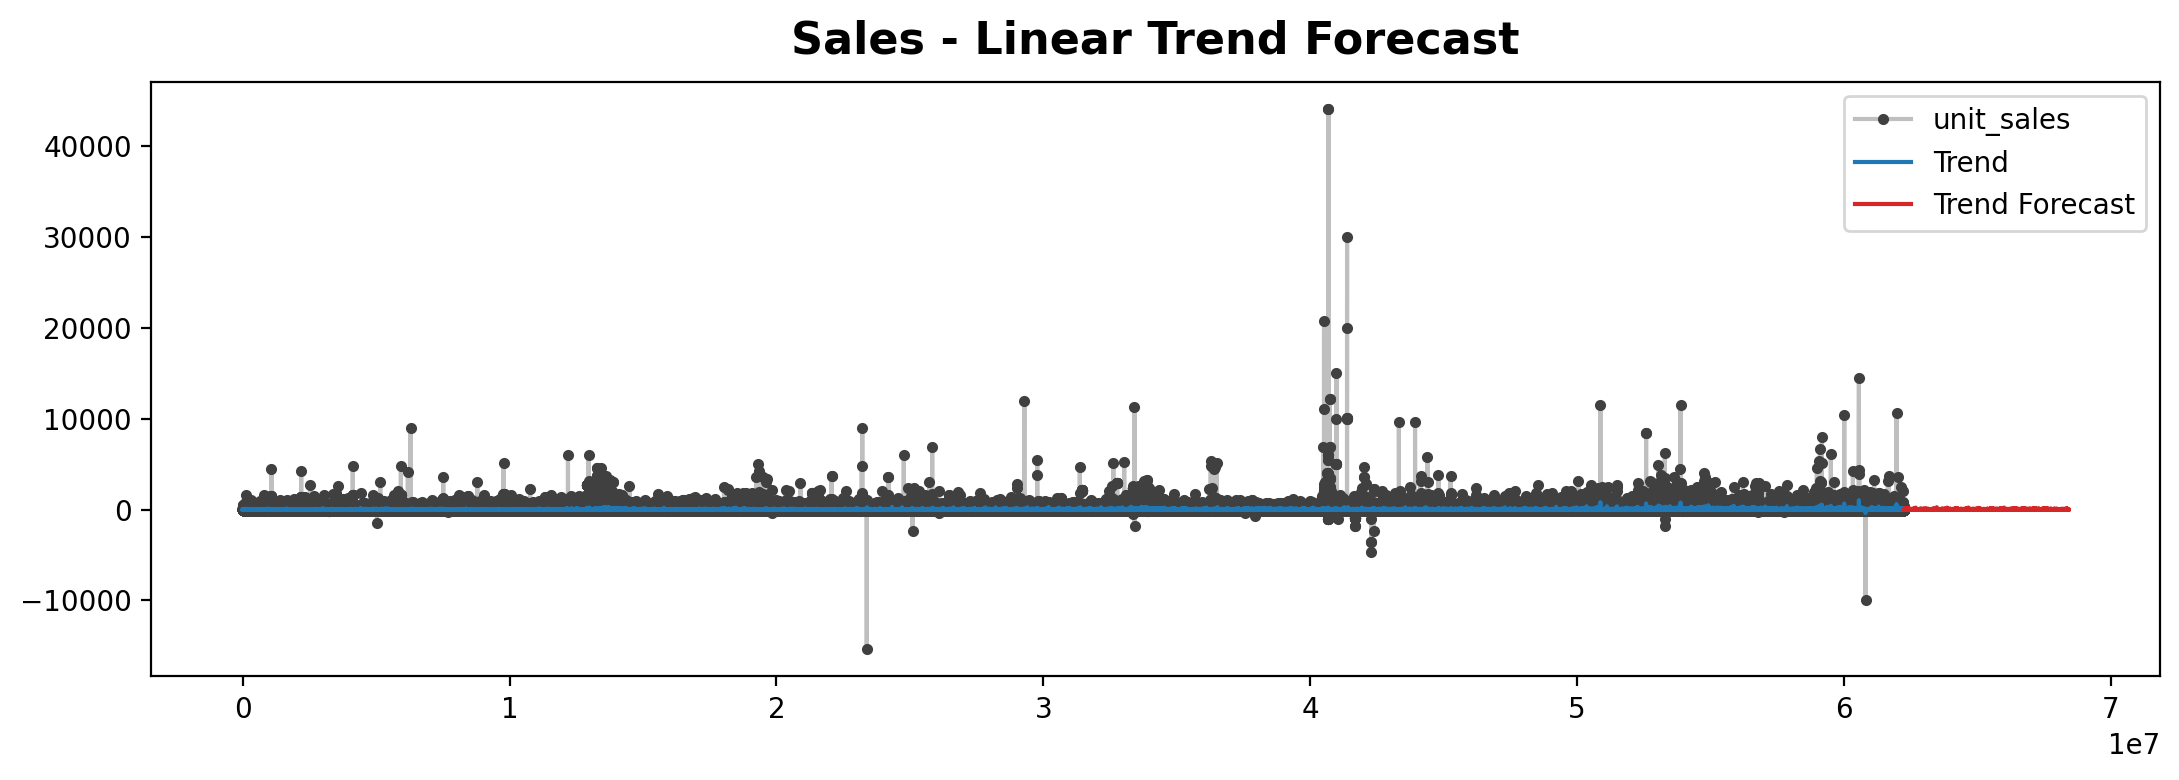

In [27]:
ax = y.plot(title="Sales - Linear Trend Forecast", **plot_params)
ax = y_pred.plot(ax=ax, label="Trend")
ax = y_fore.plot(ax=ax, label="Trend Forecast", color="C3")
_ = ax.legend()

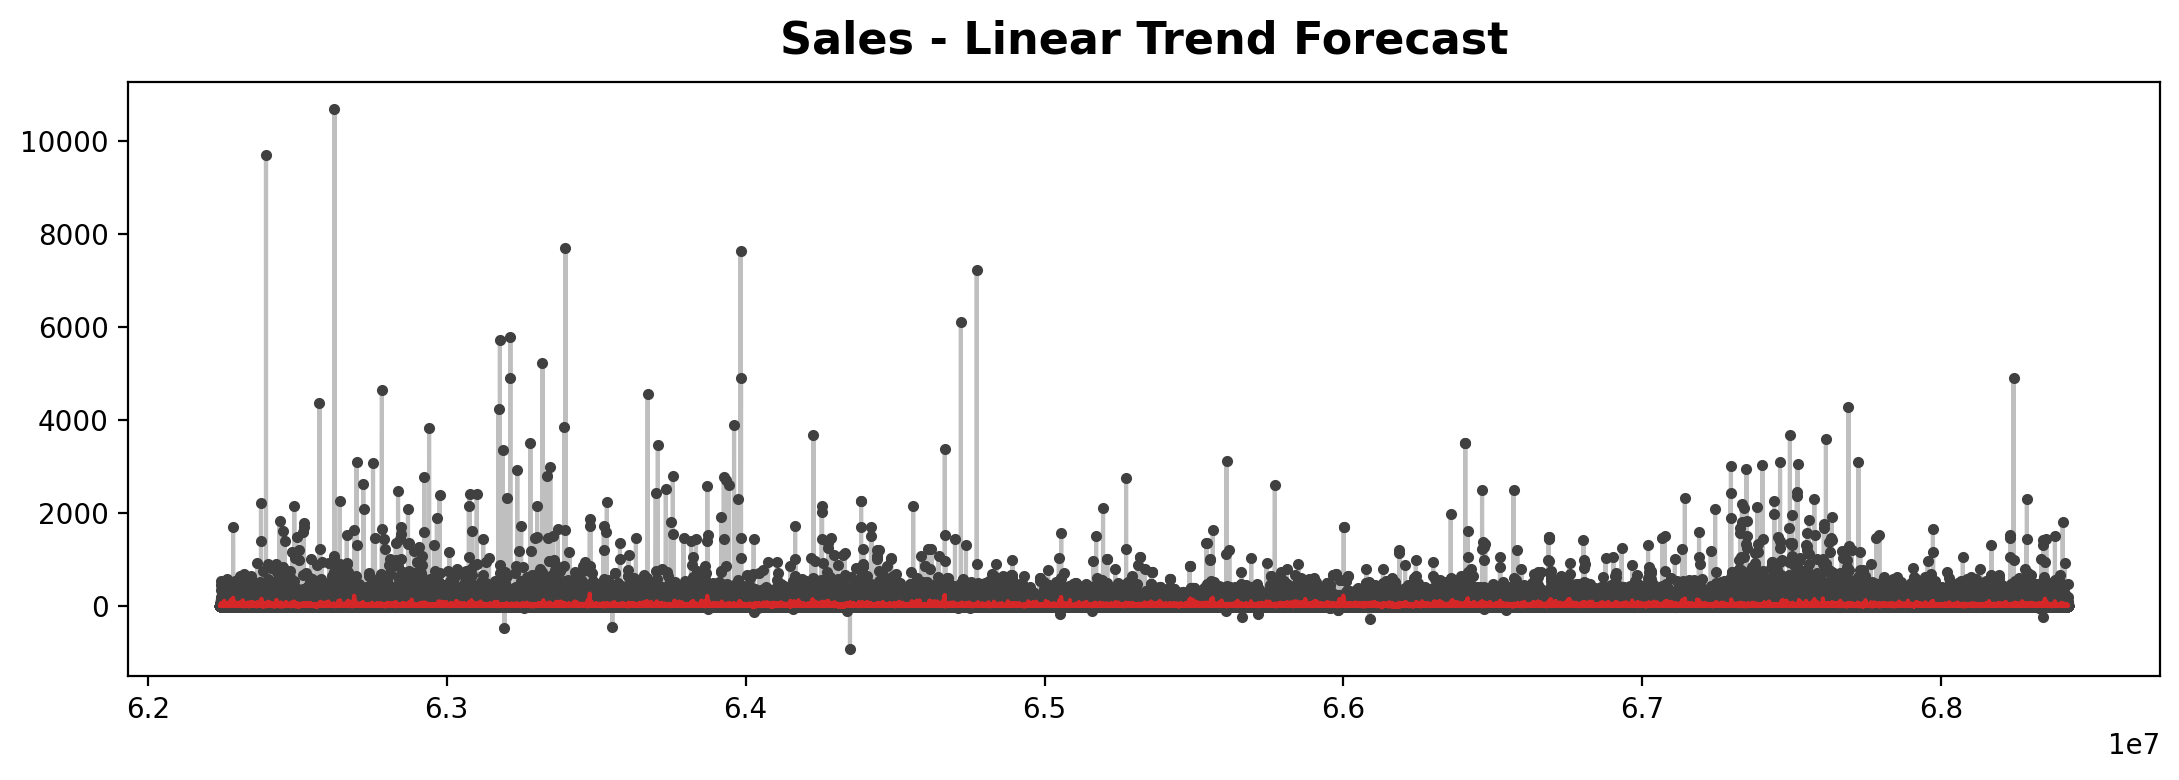

In [28]:
ax = test_data_encoded['unit_sales'].plot(title="Sales - Linear Trend Forecast", **plot_params)
ax = y_fore.plot(ax=ax, label="Trend Forecast", color="C3")